In [42]:
import os, requests
import pandas as pd
import nglview as nv
import matplotlib.pyplot as plt
import MDAnalysis as mda
from ipywidgets import Output

<a id="input"></a>
## Input parameters

**Input parameters** needed:
 - **MD_id**: PDB code of the protein structure (e.g. [A01M6](https://mmb-dev.mddbr.eu/#/id/A01M6/overview))

In [43]:
MD_id = 'A01M6'
steps = 1500
lipid_sel = '(resname DPPC and name P8)'
ngl_sel = 'DPPC'
ngl_hd_sel = f'{ngl_sel} and _P'

# common arguments for all the components
input_top_path = f'data/{MD_id}.pdb'
input_traj_path = f'data/{MD_id}.xtc'

#
disable_logs = True

<a id="fetch"></a>
***
## Fetching structure and trajectory

In [3]:
# Check if folders 'out' and 'tmp' exist and create them if not
for folder in ['out', 'data']:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")

# Check if PDB and XTC files already exist
if not os.path.exists(f"data/{MD_id}.pdb"):
    # Download PDB
    headers = {'accept': 'chemical/x-pdb'}
    url = f"https://mmb-dev.mddbr.eu/api/rest/v1/projects/{MD_id}/files/structure.pdb"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        pdb_content = response.text
        # Save the PDB content to a file
        with open(f"{MD_id}.pdb", 'w') as pdb_file:   
            pdb_file.write(pdb_content)
        print(f"Saved PDB file")
    else:
        print(f"Error for the PDB file: {response.status_code}")

if not os.path.exists(f"data/{MD_id}.xtc"): 
    # Download XTC
    headers2 = {'accept': 'application/octet-stream'}
    url2= f'https://mmb-dev.mddbr.eu/api/rest/v1/projects/{MD_id}/files/trajectory.xtc'
    response2 = requests.get(url2, headers=headers2)
    if response2.status_code == 200:
        xtc_content = response2.content
        with open(f"{MD_id}.xtc", 'wb') as xtc_file:
            xtc_file.write(xtc_content)
        print(f"Saved XTC file")
    else:
        print(f"Error for the XTC file: {response2.status_code}")

In [4]:
view = nv.show_file(input_top_path)
view

NGLWidget()

<a id="fatslim"></a>
***
## Membrane identification with FATSLiM

Membrane identification...<br>
***
**Building Blocks** used:
 - [FatslimMembranes](https://biobb-mem.readthedocs.io/en/latest/fatslim.html#module-fatslim.fatslim_membranes) from **biobb_mem.fatslim.fatslim_membranes**
***

In [2]:
from biobb_mem.fatslim.fatslim_membranes import fatslim_membranes
from biobb_mem.fatslim.fatslim_membranes import display_fatslim

/home/rchaves/miniforge3/envs/biobb_mem/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


### FATSLiM examples

In [7]:
# From https://github.com/FATSLiM/fatslim/tree/master/fatslimlib/test/data
if not os.path.exists(f"data/bilayer_multi.gro"):
    !wget https://raw.githubusercontent.com/FATSLiM/fatslim/refs/heads/master/fatslimlib/test/data/bilayer_multi.gro -P data

if not os.path.exists(f"data/dppc_vesicle.gro"):
    !wget https://raw.githubusercontent.com/FATSLiM/fatslim/refs/heads/master/fatslimlib/test/data/dppc_vesicle.gro -P data

# From https://cgmartini.nl/docs/downloads/example-applications/micelles.html:
if not os.path.exists(f"data/dpc.gro"):
    !wget https://cgmartini-library.s3.ca-central-1.amazonaws.com/1_Downloads/example_applications/micelles/dpc.gro -P data

In [ ]:
lipid_sel_CG='name PO4'
prop_CG = {
        'selection': lipid_sel_CG,
        'cutoff': 2.2,
        'ignore_no_box': True,
        'disable_logs': disable_logs
    }
tops  = ['data/dpc.gro', 'data/bilayer_multi.gro', 'data/dppc_vesicle.gro']
outs  = ['out/dpc.ndx', 'out/bilayer_multi.ndx', 'out/dppc_vesicle.ndx']
views = []
for top,out in zip(tops, outs):
    fatslim_membranes(input_top_path=top,
                    output_ndx_path=out,
                    properties=prop_CG)
    view = display_fatslim(top,lipid_sel_CG,output_ndx_path=out, leaflets=True)
    view.add_ball_and_stick(selection='.PO4', color='white') # headgroups
    view.layout.width = '100%'
    views.append(view)

2024-12-09 18:03:05,162 [MainThread  ] [INFO ]  Module: biobb_mem.fatslim.fatslim_membranes Version: 5.0.2
2024-12-09 18:03:05,163 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_ebea22a6-899d-472a-9e0a-8f97a8ee8a16 directory successfully created
2024-12-09 18:03:05,164 [MainThread  ] [INFO ]  Copy: data/dpc.gro to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_ebea22a6-899d-472a-9e0a-8f97a8ee8a16
2024-12-09 18:03:05,267 [MainThread  ] [INFO ]  fatslim membranes -n e56e7423-8bd8-4365-a950-00462824fd5a/headgroups.ndx -c /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_ebea22a6-899d-472a-9e0a-8f97a8ee8a16/dpc.gro --output-index 3cf3c622-8770-44ec-8012-9617ac72fa95/output.ndx --cutoff 2.2 --begin-frame -1 --end-frame -1

2024-12-09 18:03:05,508 [MainThread  ] [INFO ]  Executing: fatslim membranes -n e56e7423-8bd8-4365-a950-00462824fd5a/headgroups.ndx -c /hom...
2024-12-09 18:03:05,509 [MainThread  ] [INFO ]  Exit code: 0

In red the lipids that do not correspond to any membrane

In [9]:
from ipywidgets import HBox
HBox(views)

### Our case

In [9]:
prop = {
    'selection': lipid_sel,
    'cutoff': 2.2,
    'ignore_no_box': True,
    'disable_logs': disable_logs
}
fatslim_membranes(input_top_path=input_top_path,
                  input_traj_path=input_traj_path,
                  output_ndx_path="out/leaflets.ndx",
                  properties=prop)


cmd_wrapper commnand print: gmx editconf -f /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_d4b8f511-0ff6-4937-bb8b-2cd9e00c248a/A01M6.pdb -o 6e204498-bd8c-44e4-a680-78e8c781fad5/output.gro -box 167.68 173.51001 126.630005 ; fatslim membranes -n cbaf3a3e-1660-4709-ba42-bffa3beb0e7c/headgroups.ndx -c 6e204498-bd8c-44e4-a680-78e8c781fad5/output.gro --output-index f8342f75-9c65-4403-83ed-0f86e6f682c2/output.ndx --cutoff 2.2 --begin-frame -1 --end-frame -1
Executing: gmx editconf -f /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_d...
Exit code: 0



0

In [11]:
view = display_fatslim(input_top_path,lipid_sel,output_ndx_path="out/leaflets.ndx")
view.add_ball_and_stick(selection=ngl_hd_sel, color='white',aspect_ratio=4) # headgroups
view.layout.height = '400px'
view

NGLWidget(layout=Layout(height='400px'))

In [ ]:
from biobb_mem.fatslim.fatslim_membranes import parse_index
parse_index??

Signature: parse_index(ndx)
Source:   
def parse_index(ndx):
    """
    Parses a GROMACS index file (.ndx) to extract leaflet groups.

    Args:
        ndx (str): Path to the GROMACS index file (.ndx).
    Returns:
        dict: A dictionary where keys are group names and values are lists of integers representing atom indices.
    """

    # Read the leaflet.ndx file
    with open(ndx, 'r') as file:
        leaflet_data = file.readlines()

    # Initialize dictionaries to store leaflet groups
    leaflet_groups = {}
    current_group = None

    # Parse the leaflet.ndx file
    for line in leaflet_data:
        line = line.strip()
        if line.startswith('[') and line.endswith(']'):
            current_group = line[1:-1].strip()
            leaflet_groups[current_group] = []
        elif current_group is not None:
            leaflet_groups[current_group].extend(map(int, line.split()))
    return leaflet_groups
File:      ~/repo/biobb_mem/biobb_mem/fatslim/fatslim_membranes.py
Typ

<a id="density"></a>
***
## Density profile

Calculate density... [amber selection masks](https://amberhub.chpc.utah.edu/atom-mask-selection-syntax/)<br>
***
**Building Blocks** used:
 - [CpptrajDensity](https://biobb-mem.readthedocs.io/en/latest/ambertools.html#module-ambertools.cpptraj_density) from **biobb_mem.ambertools.cpptraj_density**
***

In [ ]:
from biobb_mem.ambertools.cpptraj_density import cpptraj_density

prop = {
    'mask': '::M ::A,B',
    'steps': steps,
    'disable_logs': disable_logs
}
cpptraj_density(input_top_path=input_top_path,
            input_traj_path=input_traj_path,
            output_cpptraj_path='out/density_mask.dat',
            properties=prop)

2024-12-05 15:24:18,789 [MainThread  ] [INFO ]  Module: biobb_mem.ambertools.cpptraj_density Version: 5.0.2
2024-12-05 15:24:18,790 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e130a480-f3dd-4c6e-a1d9-3e64bff3c1bb directory successfully created
2024-12-05 15:24:18,792 [MainThread  ] [INFO ]  Copy: data/A01M6.pdb to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e130a480-f3dd-4c6e-a1d9-3e64bff3c1bb
2024-12-05 15:24:19,367 [MainThread  ] [INFO ]  Copy: data/A01M6.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e130a480-f3dd-4c6e-a1d9-3e64bff3c1bb
2024-12-05 15:24:19,367 [MainThread  ] [INFO ]  cpptraj -i 12090ea6-2d44-486b-8d7f-443f222c576c/instructions.in

2024-12-05 15:24:19,546 [MainThread  ] [INFO ]  Executing: cpptraj -i 12090ea6-2d44-486b-8d7f-443f222c576c/instructions.in...
2024-12-05 15:24:19,547 [MainThread  ] [INFO ]  Exit code: 0
2024-12-05 15:24:19,548 [MainThread  ] [INFO ]  
CPPTRAJ: Trajectory 

0

In [8]:
def plot_and_view(den,view,labels,axis='z'):
    axis = f'#{axis.upper()}'
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    cls = den.columns[1:]
    cls = den.columns[1:]
    for i,cl in enumerate(cls):
        if i%2==0:
            ax.plot(den[axis], den[cl], label=labels[i//2])
            cl0 = cl
        else:
            ax.fill_between(den[axis], den[cl0] - den[cl], den[cl0] + den[cl],label='SD',color='red')
    ax.set_title('Mass Density');ax.set_xlabel('Å')
    ax.set_ylabel('Density'); ax.legend()

    # Put plot in a widget and display both widgets in a row
    out = Output()
    with out: plt.show()
    box = HBox([out,view]); display(box)
    view._remote_call('setSize', target='Widget', args=['100%', '100%'])
    view.control.spin([0, 1, 0], -1.57) 

In [9]:
# Mask
view = nv.show_file(input_top_path)
den = pd.read_csv(f'out/density_mask.dat', sep='\s+')
plot_and_view(den,view,['Membrane','Protein'])
view.update_ball_and_stick(color='blue')
view.update_cartoon(color='orange')
#view.layout.height = 'full'

<a id="leaflets"></a>
***
## Leafleats assignation

Lyphilic is faster that fatslim, it algorithm is simpler, assumes a plane membrane, it let you do the assignation of leafleats for every frame and use this information for analysis like flip-flop <br>
***
**Building Blocks** used:
 - [LPPAssignLeaflets](https://biobb-mem.readthedocs.io/en/latest/lipyphilic_biobb.html#module-lipyphilic_biobb.lpp_assign_leaflets) from **from biobb_mem.lipyphilic_biobb.lpp_assign_leaflets**
***

![DPPC](../html/DPPC.png "DPPC")

In [4]:
from biobb_mem.lipyphilic_biobb.lpp_assign_leaflets import lpp_assign_leaflets

prop = {
    'lipid_sel': lipid_sel,
    'steps': steps,
    'disable_logs': disable_logs
}
lpp_assign_leaflets(input_top_path=input_top_path,
                    input_traj_path=input_traj_path,
                    output_leaflets_path= 'out/leaflets_data.csv',
                    properties=prop)

0

In [8]:
from biobb_mem.lipyphilic_biobb.lpp_assign_leaflets import display_nglview
view = display_nglview(input_top_path, 'out/leaflets_data.csv')
view.control.spin([0, 1, 0], -1.57)
view

NGLWidget()

<a id="thickness"></a>
***
## Z positions and membrane thickness

Thicknes...<br>
***
**Building Blocks** used:
 - [LPPZPositions](https://biobb-mem.readthedocs.io/en/latest/lipyphilic_biobb.html#module-lipyphilic_biobb.lpp_zpositions) from **from biobb_mem.lipyphilic_biobb.lpp_zpositions**
***

In [40]:
from biobb_mem.lipyphilic_biobb.lpp_zpositions import lpp_zpositions

In [44]:
prop = {
    'lipid_sel': lipid_sel,
    'steps': steps,
    'height_sel': lipid_sel,
    'disable_logs': disable_logs
}
lpp_zpositions(input_top_path=input_top_path,
            input_traj_path=input_traj_path,
            output_positions_path='out/zpositions.csv',
            properties=prop)

0

In [45]:
u = mda.Universe(input_top_path, input_traj_path)

# https://docs.mdanalysis.org/stable/documentation_pages/selections.html
around_sel = '(cyzone 50 70 -50 protein)'
around_resnums = u.select_atoms(around_sel).resnums
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_point(selection=ngl_sel, color='red')
view.add_point(selection=f'({", ".join(map(str, around_resnums))}) and not protein', color='green')
view.add_point(selection='protein', color='blue')
view

NGLWidget(max_frame=10000)

In [48]:
prop = {
    'lipid_sel': lipid_sel,
    'steps': steps,
    'height_sel': f'{lipid_sel} and {around_sel}',
    'disable_logs': disable_logs
}
lpp_zpositions(input_top_path=input_top_path,
            input_traj_path=input_traj_path,
            output_positions_path='out/zpositions_around.csv',
            properties=prop)

0

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


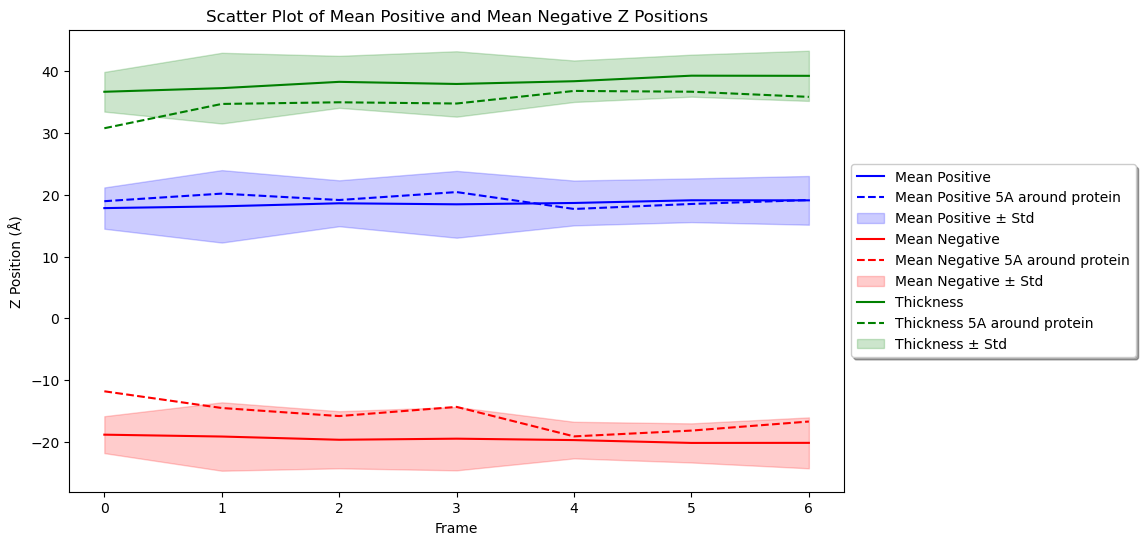

In [47]:
from biobb_mem.lipyphilic_biobb.lpp_zpositions import frame_df
import matplotlib.pyplot as plt

grouped = frame_df('out/zpositions.csv')
around = frame_df('out/zpositions_around.csv')
plt.figure(figsize=(10, 6))
# Plot the mean positive and mean negative z positions
plt.plot(grouped['mean_positive'], label='Mean Positive', linestyle='-', color='blue')
plt.plot(around['mean_positive'], label='Mean Positive 5A around protein', linestyle='--', color='blue')
plt.fill_between(grouped.index, grouped['mean_positive'] - grouped['std_positive'], grouped['mean_positive'] + grouped['std_positive'], color='blue', alpha=0.2, label='Mean Positive ± Std')
plt.plot(grouped['mean_negative'], label='Mean Negative', linestyle='-', color='red')
plt.plot(around['mean_negative'], label='Mean Negative 5A around protein', linestyle='--', color='red')
plt.fill_between(grouped.index, grouped['mean_negative'] - grouped['std_negative'], grouped['mean_negative'] + grouped['std_negative'], color='red', alpha=0.2, label='Mean Negative ± Std')
plt.plot(grouped['thickness'], label='Thickness', linestyle='-', color='green')
plt.plot(around['thickness'], label='Thickness 5A around protein', linestyle='--', color='green')
plt.fill_between(grouped.index, grouped['thickness'] - grouped['std_thickness'], grouped['thickness'] + grouped['std_thickness'], color='green', alpha=0.2, label='Thickness ± Std')
plt.title('Scatter Plot of Mean Positive and Mean Negative Z Positions')
plt.ylabel('Z Position (Å)'); plt.xlabel('Frame')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, fancybox=True, shadow=True)
plt.show()

In [67]:
view = nv.show_mdanalysis(u)
view.clear_representations()
#view.add_cartoon(color='awesome')
view.add_ball_and_stick(selection=ngl_hd_sel,aspect_ratio=8)
view.add_cartoon(selection='protein', color='grey')
#view.control.spin([0, 1, 0], -1.57)
view.layout.height = '500px'
view.background = 'grey'

In [ ]:
# https://projects.volkamerlab.org/teachopencadd/talktorials/T017_advanced_nglview_usage.html#Custom-coloring-schemes-and-representations
template = """
this.atomColor = function(atom) {
    let zPos = atom.z - %(midplane_z)f;
    let std = 3 * %(std)f;
    let ratio, r, g, b, layerZ;
    
    if (zPos > 0) { // top leaflet
        layerZ = %(top_z)f;
    } else { // bottom leaflet
        layerZ = -1 * %(bot_z)f;
        zPos = -zPos;
    }
    
    if (zPos >= layerZ) { // thickening
        ratio = (zPos - layerZ) / std;
        ratio = Math.min(1, ratio);
        r = Math.floor(255 * (1 - ratio));
        g = Math.floor(255 * (1 - ratio)); 
        b = 255;
    } else { // thinning
        ratio = -(zPos - layerZ) / std;
        ratio = Math.min(1, ratio);
        r = 255;
        g = Math.floor(255 * (1 - ratio));
        b = Math.floor(255 * (1 - ratio));
    }
    return (r << 16) + (g << 8) + b;
}
"""

top_z = grouped['mean_positive'].mean()
bot_z = grouped['mean_negative'].mean()
std   = grouped['std_thickness'].mean()
top_z, bot_z, std
# from traitlets import observe
midplane_z = [u.trajectory[i].positions[u.select_atoms(lipid_sel).indices].mean(axis=0)[2] for i in range(0, u.trajectory.n_frames, steps)]
def on_frame_change(change):
    frame = change['new']
    # We have to change the color registry name to trigger the update
    subframe = frame // steps
    js_function_combined = template % {
        'midplane_z': midplane_z[subframe],
        'std': std,
        'top_z': top_z,
        'bot_z': bot_z
    }
    # We have to change the color registry name to trigger the update
    nm = "local_dist"+str(subframe)
    nv.color.ColormakerRegistry.add_scheme_func(nm, js_function_combined)
    view.update_ball_and_stick(color=nm)
        
view.observe(on_frame_change, names=['frame'])

In [70]:
view

NGLWidget(background='grey', layout=Layout(height='500px'), max_frame=10000)

<a id="channel"></a>
***
## Channel

Chanel... <br>
***
**Building Blocks** used:
 - [MDAHole](https://biobb-mem.readthedocs.io/en/latest/mdanalysis_biobb.html#mdanalysis_biobb.mda_hole.MDAHole) from **from biobb_mem.mdanalysis_biobb.mda_hole**
***

In [1]:
from biobb_mem.mdanalysis_biobb.mda_hole import mda_hole

prop = {
    'select': 'protein',
    'steps': steps,
    'sample': 0.1,
    'disable_logs': disable_logs
}
mda_hole(input_top_path=input_top_path,
         input_traj_path=input_traj_path,
         output_hole_path='out/hole.vmd',
         properties=prop)

/home/rchaves/miniforge3/envs/biobb_mem/lib/python3.10/site-packages/MDAnalysis/analysis/hole2/__init__.py:47: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.analysis.hole2 is deprecated in favour of the MDAKit madahole2 (https://www.mdanalysis.org/mdahole2/) and will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


NameError: name 'steps' is not defined

In [14]:
from biobb_mem.mdanalysis_biobb.mda_hole import display_hole
display_hole(input_top_path, opacity=0.9)

NGLWidget()